# Описание проекта

Интернет- магазин собирает историю покупателей, проводит рассылки предложенийи планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

# Цель проекта

Предсказать вероятность покупки в течение 90 дней

# Задачи проекта

- изучить данные;
- разработать полезные признаки;
- создать модель для классификации пользователей;
- улучшить модель и максимизировать мктрику roc-auc;
- выполнить тестирование

# Данные

**apparel-purchases (история покупок)**

- **client_id** - идентификатор клиента
- **quantity** - количество единиц товара
- **price** - цена товара
- **category_ids** - идентификаторы категорий
- **date** - дата покупки
- **message_id** - идентификатор сообщения из рассылкисылки

**apparel-messages (история рекламных рассылок)**

- **bulk_campaign_id** - идентификатор рекламной кампании
- **client_id** - идентификатор пользователя
- **message_id** - идентификатор сообщения
- **event** - тип действия
- **channel** - канал рассылки
- **date** - дата рассылки
- **created_at** - точное время создания сообщения

**apparel-target_binary (совершит ли клиент покупку в течении следующих 90 дней)**

- **client_id** - идентификатор пользователя
- **target** - целевой признак

# Содержание

[1. Загрузка исходных датасетов с данными](#chapter1)

[2. Предобработка данных](#chapter2)
- [Датасет df_messages](#chapter21)
- [Датасет df_purchases](#chapter22)
- [Датасет df_target](#chapter23)
- [Объединённый датасет df_main (df_purchases_group + df_messages_group + df_target)](#chapter24)

[3. Исследовательский анализ данных](#chapter3)

[4. Обучение моделей](#chapter4)

[5. Анализ лучшей модели](#chapter5)

[6. Итоговый вывод](#chapter6)

# Импорт библиотек, моделей, метрик

In [221]:
# загрузка инсталяций:
!pip install -U scikit-learn
!pip install shap -q
!pip install phik
!pip install missingno
!pip install optuna-integration[sklearn]
!pip install catboost
!pip install lightgbm
!pip install tqdm
!pip install skimpy pandas
!pip freeze > requirements.txt

In [222]:
#загрузка библиотек:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import shap
import re
from phik import report
import missingno as msno
from plotly import graph_objects as go
from skimpy import skim, generate_test_data
from skimpy import clean_columns
pd.options.mode.chained_assignment = None

#загрузка модели/метрики:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from optuna.integration import OptunaSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    LabelEncoder
) 

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    f1_score,
    mean_squared_error,
    make_scorer,
    confusion_matrix,
    roc_curve,
    RocCurveDisplay
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from optuna import distributions
from phik.report import plot_correlation_matrix
from tqdm.notebook import tqdm
from numpy.random import RandomState
from sklearn.compose import ColumnTransformer

In [223]:
RANDOM_STATE = 1234
TEST_SIZE = 0.25

<a class="anchor" id="chapter1"></a>

### Загрузка исходных датасетов с данными

In [224]:
df_messages = pd.read_csv('C:/Users/TOR/study/datasets2/apparel_messages.csv', parse_dates=['date', 'created_at'])
df_purchases = pd.read_csv('C:/Users/TOR/study/datasets2/apparel_purchases.csv', parse_dates=['date'])
df_target = pd.read_csv('C:/Users/TOR/study/datasets2/apparel_target_binary.csv')

In [225]:
def main_info(df):
    display(df.sample(7))
    i = df.info()
    display(df.describe().T)
    return i

In [226]:
main_info(df_messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
7081546,13681,1515915625633755061,1515915625633755061-13681-64df57b09a6c2,send,mobile_push,2023-08-18,2023-08-18 12:28:54
7293400,13732,1515915625559885644,1515915625559885644-13732-64ec6f81d5778,send,email,2023-08-28,2023-08-28 10:25:13
11701155,14502,1515915625557297498,1515915625557297498-14502-65aa366fdbf7b,send,email,2024-01-19,2024-01-19 08:58:21
431360,5052,1515915625487199191,1515915625487199191-5052-62b2c1a3f30c2,send,email,2022-06-22,2022-06-22 07:39:38
4630985,11208,1515915625488422643,1515915625488422643-11208-6423f10f3fd1d,click,email,2023-04-02,2023-04-02 03:58:41
3558683,9264,1515915625472987375,1515915625472987375-9264-63be69b805934,open,email,2023-01-11,2023-01-11 14:23:52
3045046,8605,1515915625706430829,1515915625706430829-8605-63974208b772f,send,mobile_push,2022-12-12,2022-12-12 15:33:38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


,count,mean,min,25%,50%,75%,max,std
bulk_campaign_id,12739798.0,11604.587587,548.0,8746.0,13516.0,14158.0,14657.0,3259.211131
client_id,12739798.0,1515915625574831616.0,1515915625468060928.0,1515915625489149440.0,1515915625503432192.0,1515915625591286272.0,1515915626010288640.0,326551798.15769
date,12739798,2023-06-05 02:46:08.357990400,2022-05-19 00:00:00,2022-12-19 00:00:00,2023-07-20 00:00:00,2023-11-21 00:00:00,2024-02-15 00:00:00,NaN
created_at,12739798,2023-06-05 13:58:11.168689408,2022-05-19 00:14:20,2022-12-19 12:46:30,2023-07-20 17:21:54,2023-11-21 18:13:05,2024-02-15 23:58:40,NaN


In [227]:
main_info(df_purchases)

,client_id,quantity,price,category_ids,date,message_id
78164,1515915625590744425,1,666.0,"['4', '31', '324', '466']",2022-12-24,1515915625468245507-8958-63a573c64534a
96983,1515915625566726077,1,1050.0,"['2', '18', '344', '445']",2023-03-29,1515915625566726077-11208-6423f06bc03d5
8349,1515915625468242212,1,1499.0,"['2', '18', '274', '450']",2022-06-03,1515915625468242212-4679-629722007d810
42963,1515915625474504025,1,490.0,"['2', '18', '267', '1330']",2022-11-10,1515915625474504025-7687-636b57263b7e9
49857,1515915625496658432,1,209.0,"['5562', '5632', '5577', '850']",2022-11-12,1515915625496658432-7803-636dfec592b98
163467,1515915625985561247,1,1900.0,"['4', '28', '213', '417']",2023-08-12,1515915625985561247-13635-64d61ac8103b2
46659,1515915625559297660,1,1049.0,"['4', '28', '249', '615']",2022-11-11,1515915625478655004-7659-6368e55966919


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


,count,mean,min,25%,50%,75%,max,std
client_id,202208.0,1515915625596210944.0,1515915625468060928.0,1515915625490081280.0,1515915625557177088.0,1515915625624391936.0,1515915626010443520.0,145951436.369225
quantity,202208.0,1.006483,1.0,1.0,1.0,1.0,30.0,0.184384
price,202208.0,1193.301516,1.0,352.0,987.0,1699.0,85499.0,1342.252664
date,202208,2023-03-17 02:49:35.739832064,2022-05-16 00:00:00,2022-11-12 00:00:00,2023-04-12 00:00:00,2023-07-03 00:00:00,2024-02-16 00:00:00,NaN


In [228]:
main_info(df_target)

,client_id,target
3585,1515915625472167504,0
21866,1515915625512624790,0
46457,1515915625919411722,0
31914,1515915625580319771,0
27981,1515915625559907881,0
9771,1515915625489088771,0
15064,1515915625490872029,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


**Вывод: На первый взгляд, информация в датасете выглядет корректной, наименования столбцов соответствуют содержанию. Для определения пропущенных значений, явных/неявных дубликатов, и оформления информации в едином стиле требуется предобработка данных**

<a class="anchor" id="chapter2"></a>

# Предобработка данных

In [229]:
# функция для получения общей информаций о пропущенных значениях и дубликатах:
def preprocessing (df):
    first_stage = df.duplicated().sum()
    second_stage = df.drop_duplicates(inplace=True)
    third_stage = df.duplicated().sum()
    fourth_stage = display(msno.matrix(df, labels=True))
    fifth_stage = df.isna().sum()
    print('Количество дубликатов:', first_stage)
    print('========================================')
    print('Количество дубликатов после удаления:', third_stage)
    print('========================================')
    print('Количество пропущенных значений:')
    print(fifth_stage)
    print('========================================')
    print('Матрица пропущенных значений:')

<a class="anchor" id="chapter21"></a>

# Датасет df_messages

<Axes: >

Количество дубликатов: 48610
Количество дубликатов после удаления: 0
Количество пропущенных значений:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
Матрица пропущенных значений:


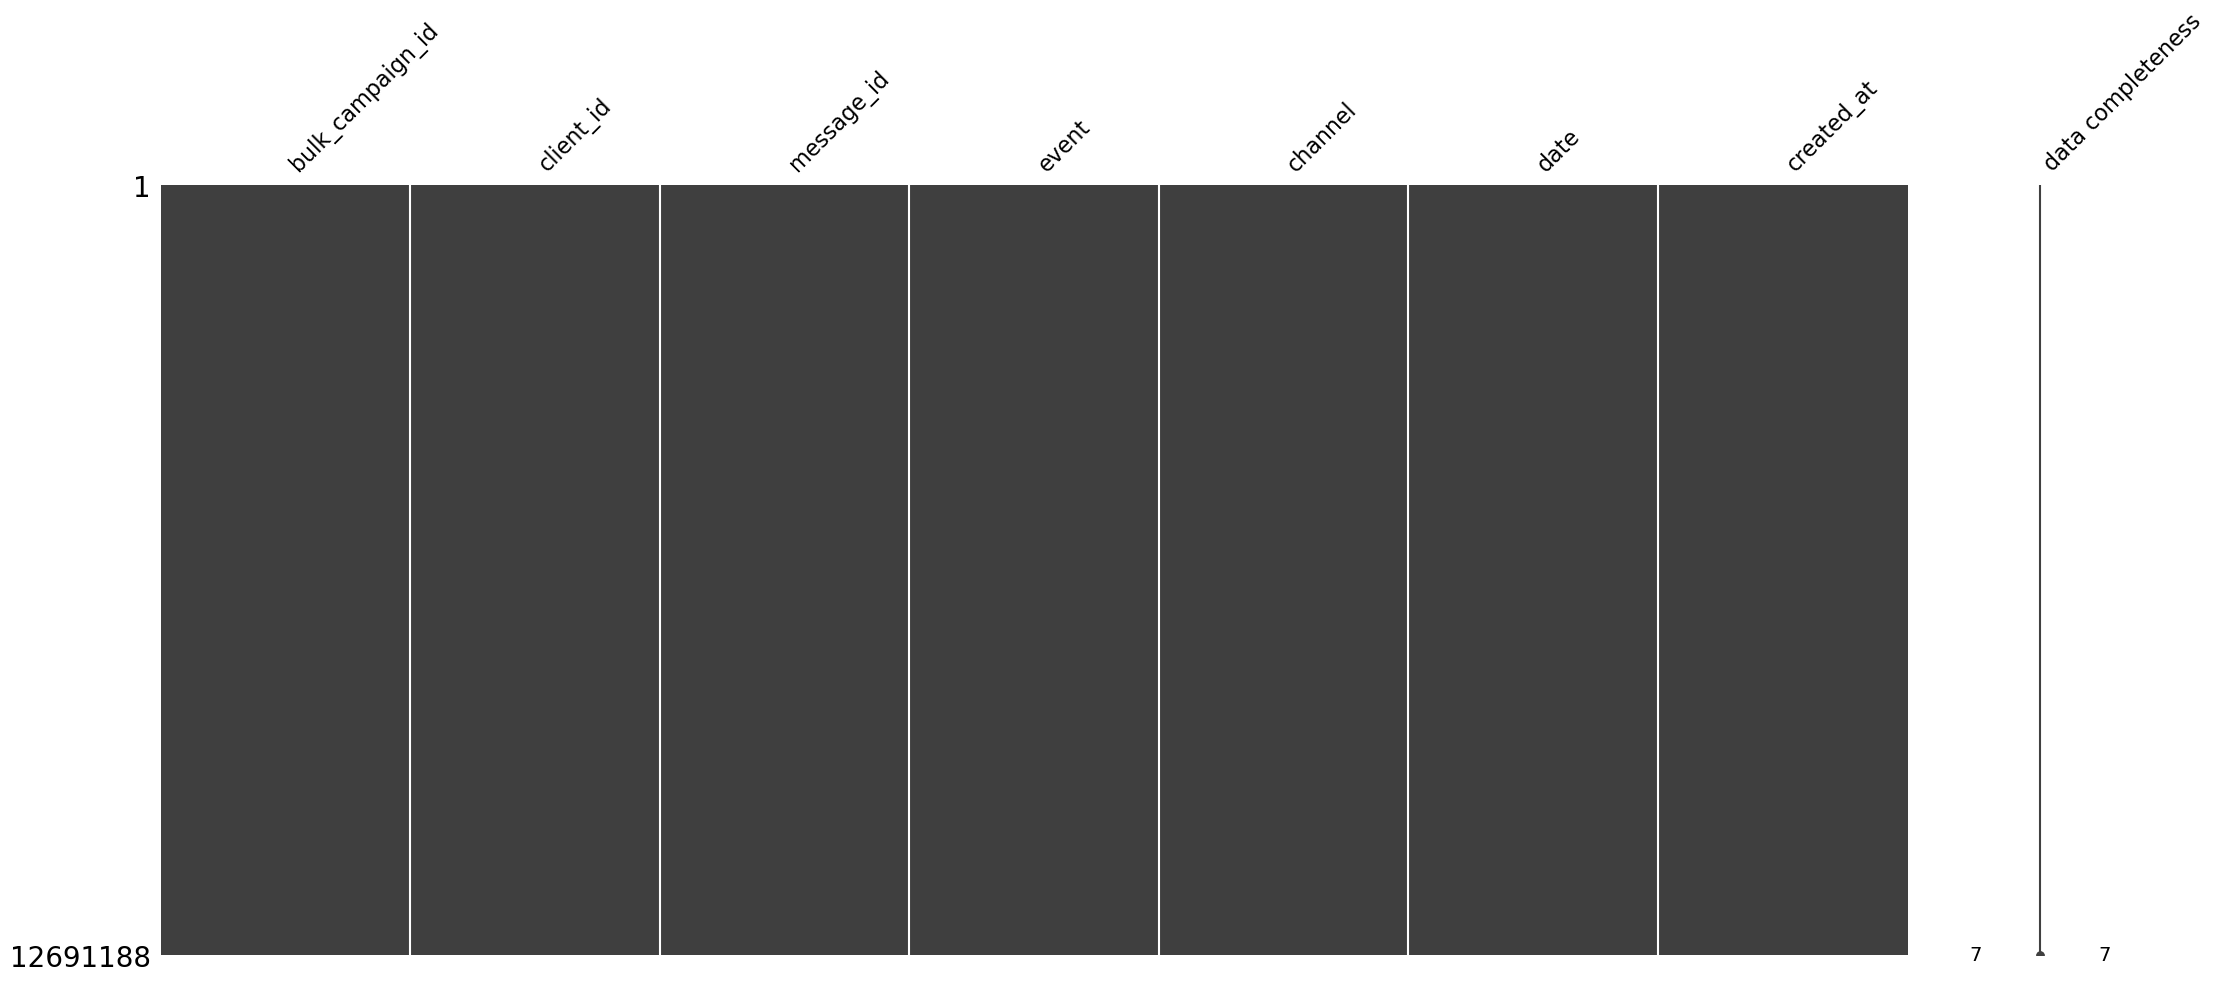

In [230]:
preprocessing(df_messages)

In [231]:
# стандартизируем столбцы по нижнему регистру, змеиному стилю, пробелам/разделителям:
df_messages = clean_columns(df_messages)
df_messages.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
223755,4710,1515915625490436475,1515915625490436475-4710-6299a5aa4d3c4,send,email,2022-06-03,2022-06-03 06:15:22
284909,4813,1515915625638648227,1515915625638648227-4813-62a0500e406a4,send,email,2022-06-08,2022-06-08 07:34:29
6451391,13543,1515915625500270780,1515915625500270780-13543-64be89fd151a3,send,mobile_push,2023-07-24,2023-07-24 14:50:58
7875357,13817,1515915625626498221,1515915625626498221-13817-650a8ca6e75e3,send,mobile_push,2023-09-20,2023-09-20 12:37:27
126794,4617,1515915625500268131,1515915625500268131-4617-6290657d50e6f,send,email,2022-05-27,2022-05-27 05:48:56


**Вывод: Пропущенных значений нет, но есть дубликаты которые подтверждаются одинаковым временем создания сообщения**

In [232]:
# функция проверки уникальных значений в категориальных столбцах:
def unique(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            print(df[i].value_counts())
            print()

In [233]:
unique(df_messages)

message_id
1515915625489095763-6251-6311b13a4cf78     1427
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625629509124-6374-63241bd1541d5      286
1515915625488270582-3433-6232d6007e929      249
                                           ... 
1515915625489968543-12052-64426bfcee0e6       1
1515915625500268486-12052-64426bfce782f       1
1515915625487017808-12052-64426bfce74d5       1
1515915625488469540-12052-64426bfce6d10       1
1515915625491736359-14656-65ce97f92a3fd       1
Name: count, Length: 9061667, dtype: int64

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64



In [234]:
# проверим разницу м/у столбцами 'date' и 'created_at'. есть предположение что они дублируют друг друга:
df_messages.query('abs((date - created_at).dt.days) > 1')['created_at'].count()

0

In [235]:
# столбцы содержат одинаковые данные, поэтому удаляем один из столбцов:
df_messages = df_messages.drop('created_at', axis=1)

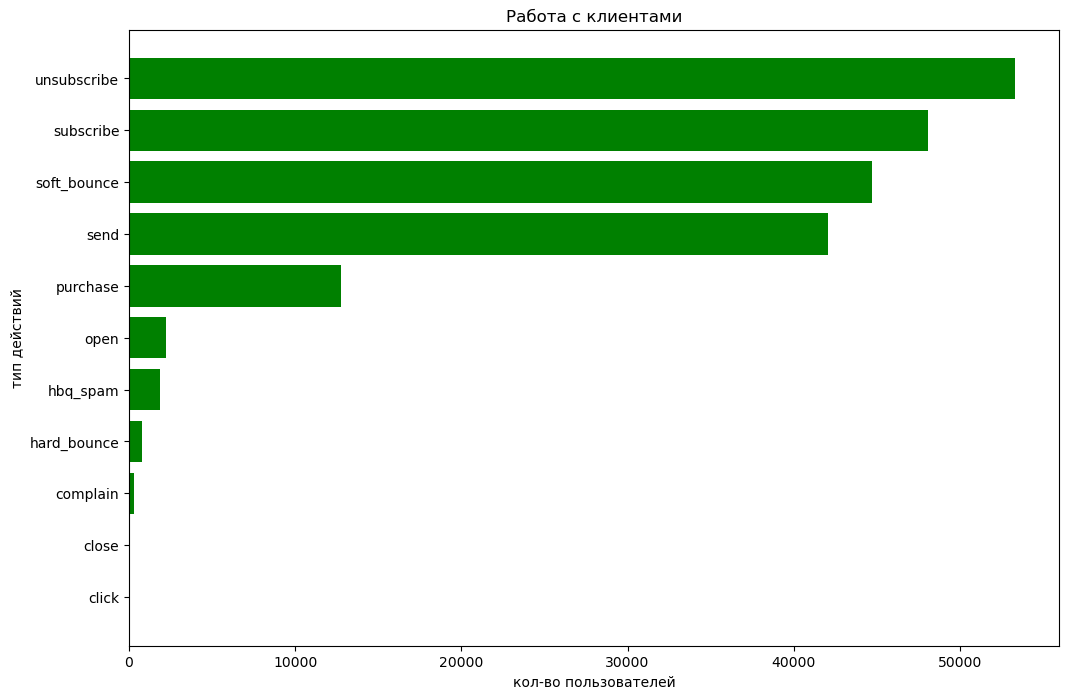

In [236]:
df_messages_event = df_messages.groupby('event')['client_id'].nunique().reset_index()
plt.figure(figsize=(12, 8))
plt.barh(df_messages_event['event'], df_messages_event['client_id'].sort_values(), color='green')
plt.xlabel('кол-во пользователей')
plt.ylabel('тип действий')
plt.title('Работа с клиентами')
plt.show()

**Вывод: Есть определенные проблемы по рассылке: сообщения уходят в спам, технические проблемы с доставкой сообщений, жалобы и отписки от клиентов. Думаю, можно удалить строки с негативными действиями т.к. это снижает вероятность покупки в ближайшей перспективе**

In [237]:
# создаем новые столбцы с положительными событиями
df_messages.loc[df_messages['channel'] == 'email', 'email'] = 1 
df_messages.loc[df_messages['channel'] == 'mobile_push', 'mobile_push'] = 1 
df_messages['email'].astype('bool')
df_messages['mobile_push'].astype('bool')
for _ in ['subscribe', 'send', 'purchase','open','click']:
    df_messages.loc[df_messages['event'] == _, _] = 1
    df_messages[_].astype('bool')      

In [238]:
# создаем группированный по клиентам датасет:
df_messages_group = df_messages.drop(columns=['bulk_campaign_id', 'message_id', 'event', 'date', 'channel']).groupby(by='client_id').sum()

In [239]:
pd.DataFrame(round(df_messages_group.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
email,0.000000
mobile_push,0.000000
subscribe,0.000000
send,0.000000
purchase,0.000000
open,0.000000
click,0.000000


In [240]:
df_messages_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   email        53329 non-null  float64
 1   mobile_push  53329 non-null  float64
 2   subscribe    53329 non-null  float64
 3   send         53329 non-null  float64
 4   purchase     53329 non-null  float64
 5   open         53329 non-null  float64
 6   click        53329 non-null  float64
dtypes: float64(7)
memory usage: 3.3 MB


**Вывод: сгруппировали/пересобрали датасет df_messages по столбцу 'client_id' кол-во записей сжалось до 53329 значений. Создали полезные признаки из столбцов 'event' и 'channel'**

<a class="anchor" id="chapter22"></a>

# Датасет df_purchases

In [241]:
df_purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

In [242]:
df_purchases.duplicated().sum()

73020

<Axes: >

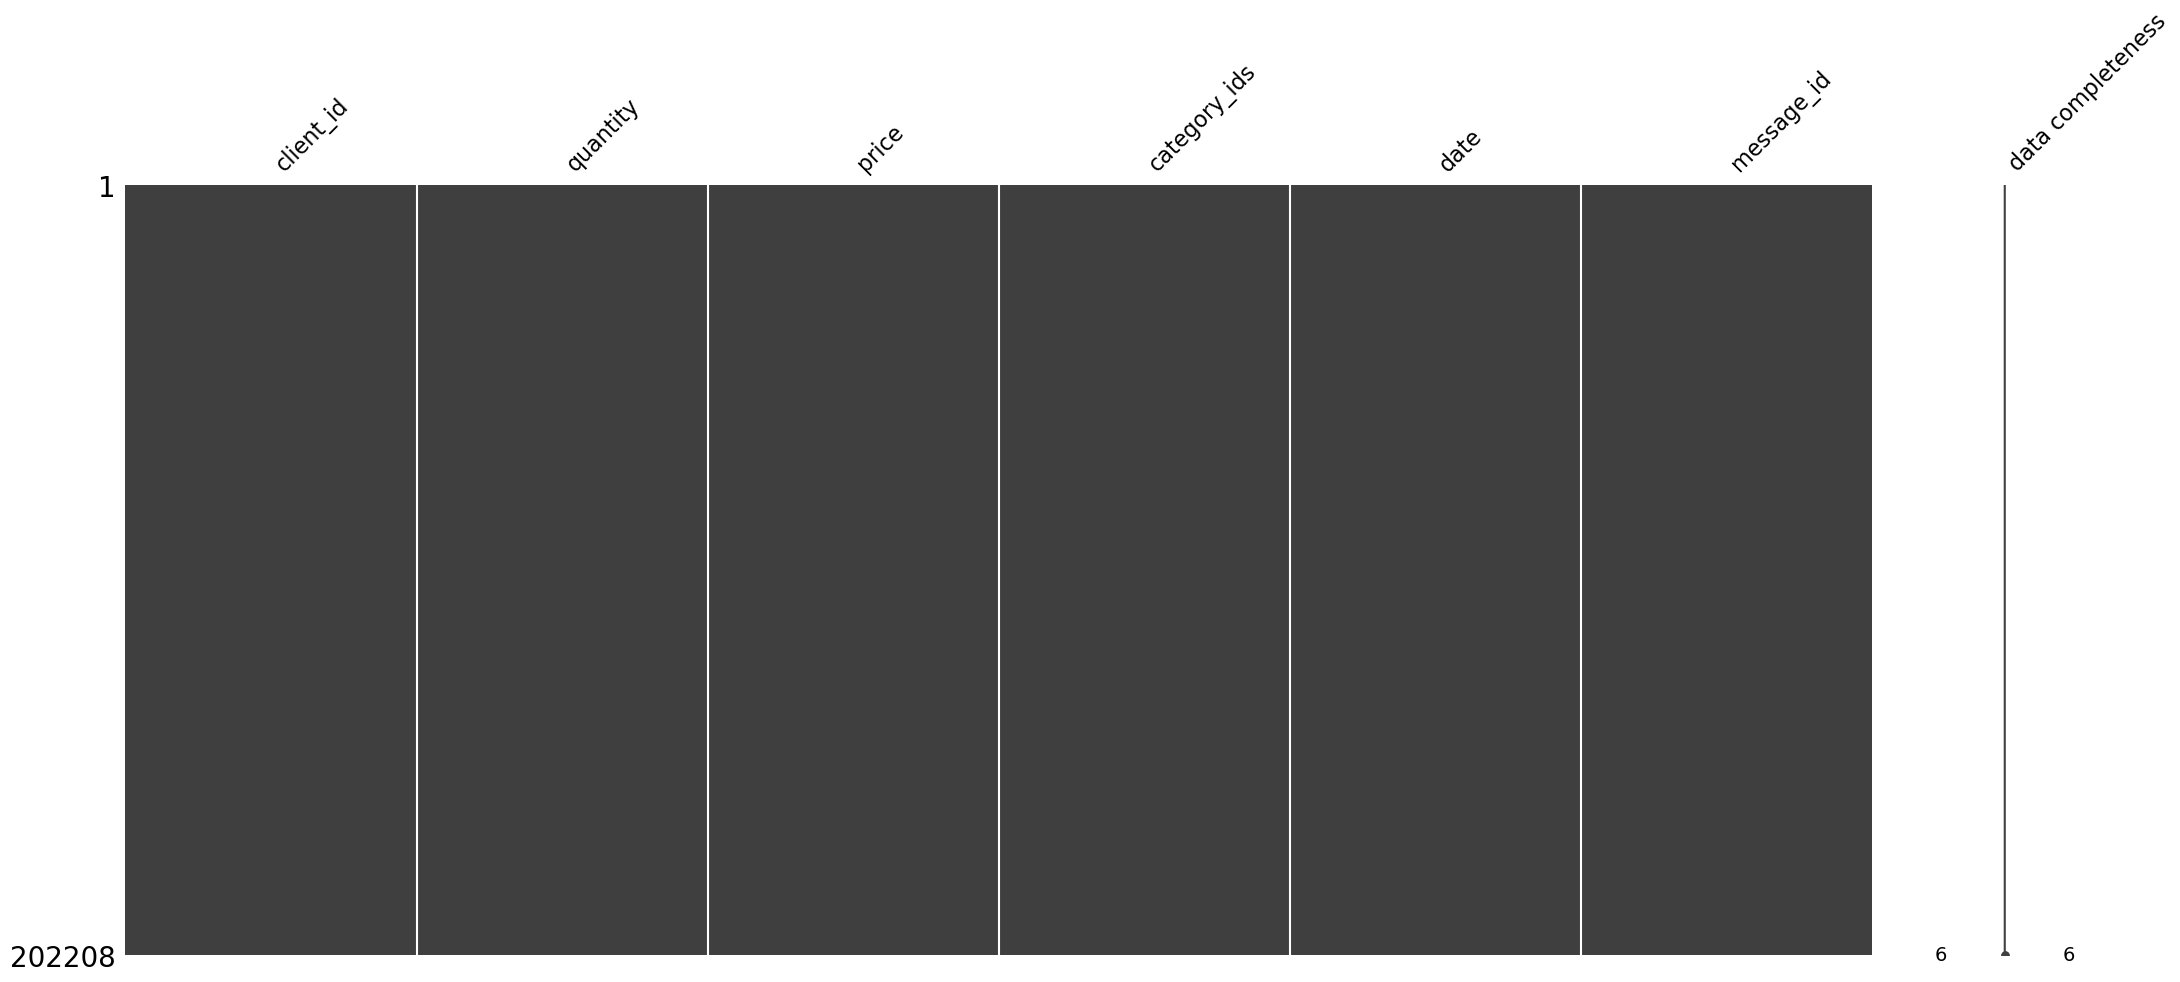

In [243]:
msno.matrix(df_purchases, labels=True)

In [244]:
df_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

**Вывод: Судя по кол-ву товаров, которые равны 1, с дубликатами нужно действовать осторожней, т.к скорее всего это не дубликаты, а заказы сделанные одним и тем же клиентом в разное время (например утром и вечером). К тому же, потеряем около 30% от всего объёма датасета**

In [245]:
# стандартизируем столбцы по нижнему регистру, змеиному стилю, пробелам/разделителям:
df_purchases = clean_columns(df_purchases)
df_purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id
91065,1515915625558681330,1,6.0,"['5562', '5597', '5691', '889']",2023-03-11,1515915625489888196-10792-640ad946867e6
160037,1515915625485385682,1,599.0,"['5562', '5630', '5649', '678']",2023-07-20,1515915625485385682-13505-64b506491f2d7
7727,1515915625559499844,1,399.0,"['5562', '5630', '5592', '676']",2022-06-02,1515915625559499844-4679-6297220791c28
1836,1515915625488546948,1,2199.0,"['4', '29', '311', '928']",2022-05-21,1515915625572914757-4492-62873cbf08eb5
118405,1515915625588693084,1,1164.0,"['4', '28', '239', '418']",2023-05-05,1515915625491584793-12367-6454f0c2eb9be


In [246]:
unique(df_purchases)

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

message_id
1515915625489095763-6251-6311b13a4cf78     365
1515915625624308268-7803-636dfea7ca890     218
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
1515915625558691508-14212-6567128370bdd    143
                                          ... 
1515915625487887289-5707-62e38257ccade       1
1515915625597731503-5707-62e38247a88c0       1
1515915625594604191-5707-62e382458eb5f       1
1515915625594340883-5739-62e3d2d9c35c2       1
151591562549532

In [247]:
# создадим новый столбец с общей стоимостью покупки:
df_purchases['total_price'] = df_purchases['price'] * df_purchases['quantity']

In [248]:
# из столбца 'category_ids' сделаем новый столбец'main_category' где оставим первое основное наименование категории:
df_purchases['category_ids'] = df_purchases['category_ids'].str.replace('[', '').str.replace(']', '').str.replace(" ", '').str.replace("'", '')
df_purchases['main_category'] = df_purchases['category_ids'].str.split(",", expand=True)[0]
df_purchases = df_purchases.drop('category_ids', axis=1)

In [249]:
# создаем группированный по клиентам датасет:
df_purchases_group = df_purchases.drop(columns=["price", "quantity", 'main_category', 'date', 'message_id']).groupby(by='client_id').sum()

In [250]:
# создадим столбец с количеством дней покупок по каждому клиенту:
df_purchases_group['dates'] = df_purchases.drop(columns=['price', 'quantity','main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').nunique()['date']
# создадим столбец с даты последней покупки:
df_purchases_group['last_data_purch'] = df_purchases.drop(columns=['price', 'quantity','main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').max()['date']
# создадим столбец с даты первой датой покупки:
df_purchases_group['first_data_purch'] = df_purchases.drop(columns=['price', 'quantity','main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').min()['date']
# создадим столбец дальности покупки:
df_purchases_group['last_purch'] = (df_purchases_group['last_data_purch'].max() - df_purchases_group['last_data_purch']).dt.days + 1

# создадим столбец с периодом покупок
df_purchases_group['period'] = (df_purchases_group['last_data_purch'] - df_purchases_group['first_data_purch']).dt.days + 1

# создадим столбец со средней периодом покупок:
df_purchases_group['mean_period'] = round((df_purchases_group['period'] / df_purchases_group['dates']), 1)

# создадим столбец со средней стоимостью заказа:
df_purchases_group['mean_invoice'] = round((df_purchases_group['total_price'] / df_purchases_group['dates']), 1)

# создадим столбец с количеством купленного товара по каждому клиенту:
df_purchases_group['quantity'] = df_purchases.drop(columns=['price', 'date','main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').sum()['quantity']

# создадим столбец с максимальной категорией купленных товаров 
df_purchases_group['main_category'] = pd.pivot_table(df_purchases, values='main_category', index=['client_id'], aggfunc='max')['main_category']
df_purchases_group['main_category'] = df_purchases_group['main_category'].replace(np.nan, '999')
# удаляем лишние столбцы
df_purchases_group = df_purchases_group.drop(columns=['last_data_purch', 'first_data_purch', 'period'])

In [251]:
pd.DataFrame(round(df_purchases_group.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_price,0.000000
dates,0.000000
last_purch,0.000000
mean_period,0.000000
mean_invoice,0.000000
quantity,0.000000
main_category,0.000000


In [252]:
df_purchases_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_price    49849 non-null  float64
 1   dates          49849 non-null  int64  
 2   last_purch     49849 non-null  int64  
 3   mean_period    49849 non-null  float64
 4   mean_invoice   49849 non-null  float64
 5   quantity       49849 non-null  int64  
 6   main_category  49849 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 3.0+ MB


**Вывод: сгруппировали/пересобрали датасет df_purchases по столбцу 'client_id' кол-во записей сжалось до 49849 значений. Создали новые полезные признаки на основе имеющихся данным. Датасет df_purchases готов к объединению с датасетом df_target**

<a class="anchor" id="chapter23"></a>

# Датасет df_target

<Axes: >

Количество дубликатов: 0
Количество дубликатов после удаления: 0
Количество пропущенных значений:
client_id    0
target       0
dtype: int64
Матрица пропущенных значений:


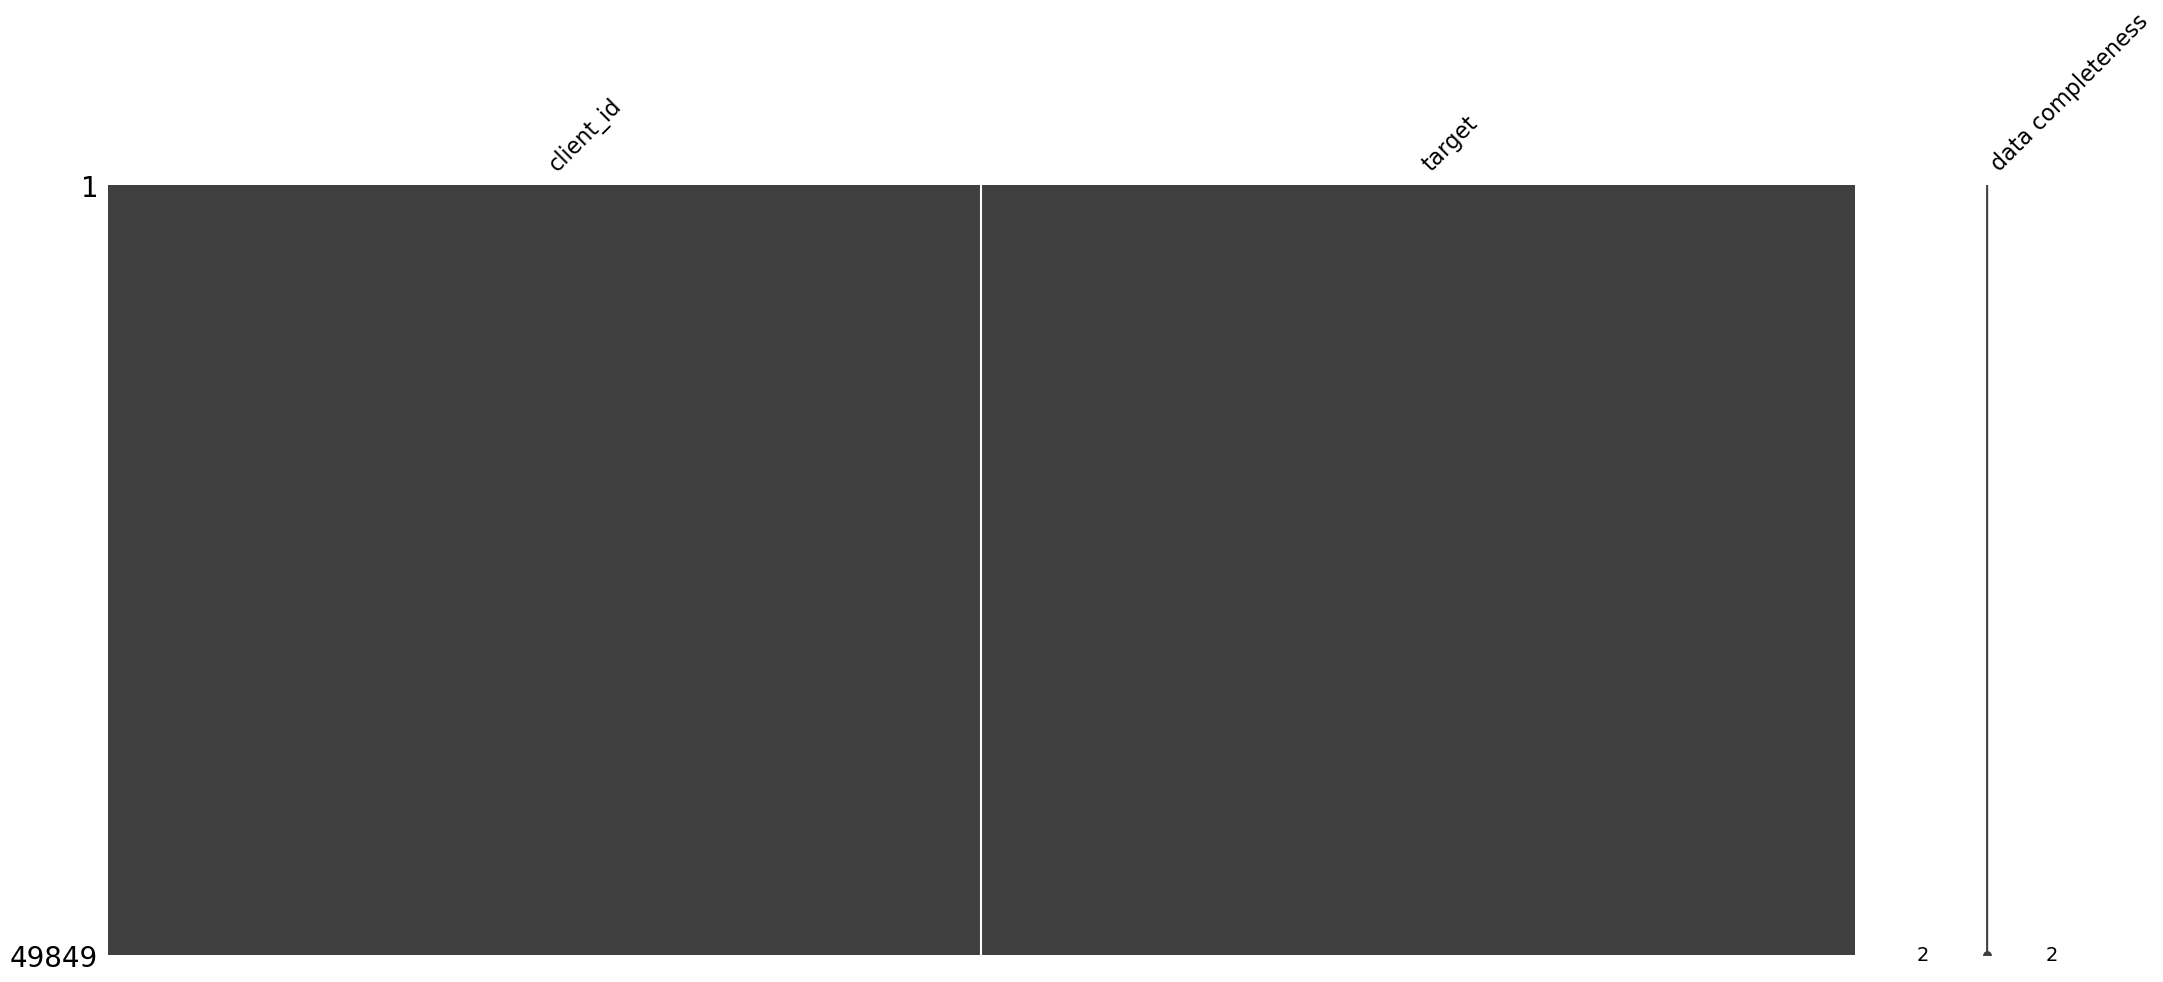

In [253]:
preprocessing(df_target)

In [254]:
# стандартизируем столбцы по нижнему регистру, змеиному стилю, пробелам/разделителям:
df_target = clean_columns(df_target)
df_target.sample(5)

,client_id,target
46755,1515915625938596979,0
25852,1515915625558342023,1
32575,1515915625583143323,0
30058,1515915625570718791,0
35489,1515915625601574570,0


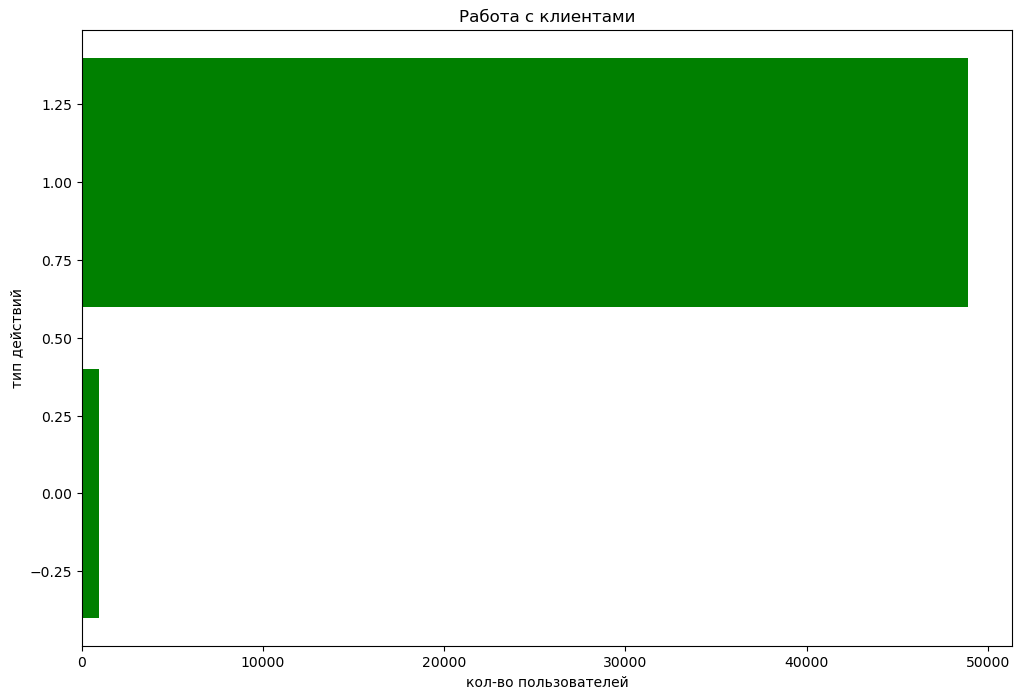

In [255]:
df_t = df_target.groupby('target')['client_id'].nunique().reset_index()
plt.figure(figsize=(12, 8))
plt.barh(df_t['target'], df_t['client_id'].sort_values(), color='green')
plt.xlabel('кол-во пользователей')
plt.ylabel('тип действий')
plt.title('Работа с клиентами')
plt.show()

**Вывод: пропущенных значений нет, дублей незамечено, но присутствует дисбаланс таргета. Перед обучением моделей нужна стратификация**

<a class="anchor" id="chapter24"></a>

# Объединённый датасет df_main (df_purchases_group + df_messages_group + df_target)

In [256]:
df_purchases_group.shape

(49849, 7)

In [257]:
df_messages_group.shape

(53329, 7)

In [258]:
df_target.shape

(49849, 2)

In [259]:
# объединяем 3 датасета в 1 общий:
df_main = df_target.join(df_purchases_group, on='client_id')
df_main = df_main.join(df_messages_group, on='client_id')

In [260]:
pd.DataFrame(round(df_main.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
client_id,0.000000
target,0.000000
total_price,0.000000
dates,0.000000
last_purch,0.000000
mean_period,0.000000
mean_invoice,0.000000
quantity,0.000000
main_category,0.000000
email,15.800000


In [261]:
# заполним пропуски нулевым значением:
df_main = df_main.fillna(0)

In [262]:
pd.DataFrame(round(df_main.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
client_id,0.000000
target,0.000000
total_price,0.000000
dates,0.000000
last_purch,0.000000
mean_period,0.000000
mean_invoice,0.000000
quantity,0.000000
main_category,0.000000
email,0.000000


In [263]:
df_main.duplicated().sum()

0

In [264]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      49849 non-null  int64  
 1   target         49849 non-null  int64  
 2   total_price    49849 non-null  float64
 3   dates          49849 non-null  int64  
 4   last_purch     49849 non-null  int64  
 5   mean_period    49849 non-null  float64
 6   mean_invoice   49849 non-null  float64
 7   quantity       49849 non-null  int64  
 8   main_category  49849 non-null  object 
 9   email          49849 non-null  float64
 10  mobile_push    49849 non-null  float64
 11  subscribe      49849 non-null  float64
 12  send           49849 non-null  float64
 13  purchase       49849 non-null  float64
 14  open           49849 non-null  float64
 15  click          49849 non-null  float64
dtypes: float64(10), int64(5), object(1)
memory usage: 6.1+ MB


**Вывод: Получили объединённый датасет для дальнейшей работы на 49849 записей, пропуски заполнили рандомным распределением значений**

<a class="anchor" id="chapter3"></a>

# Исследовательский анализ данных

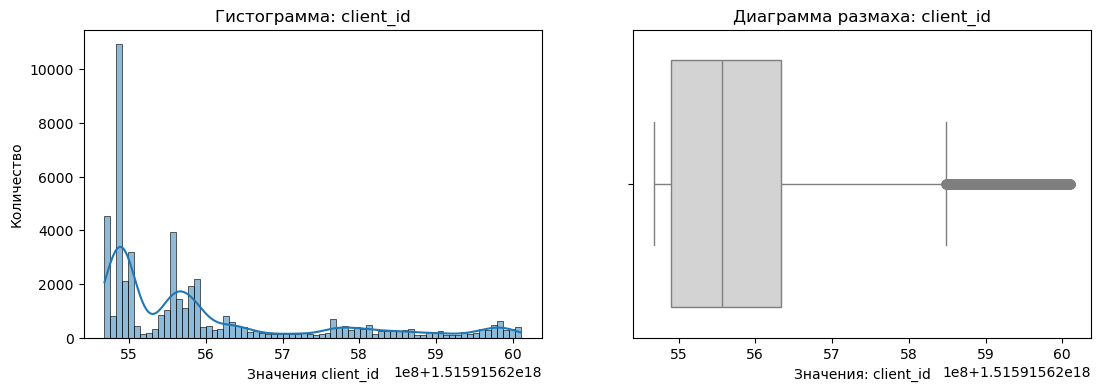

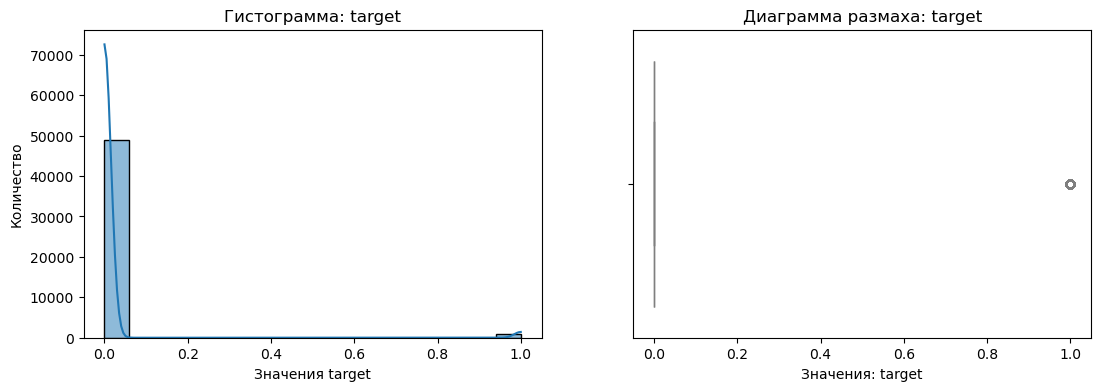

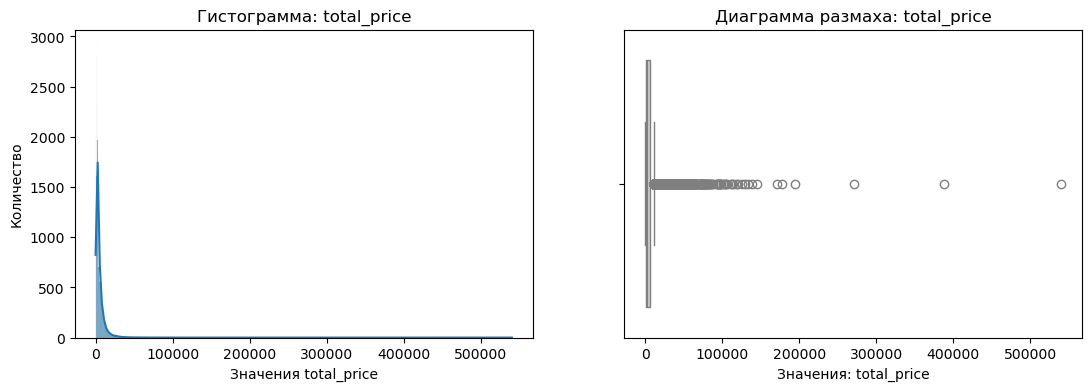

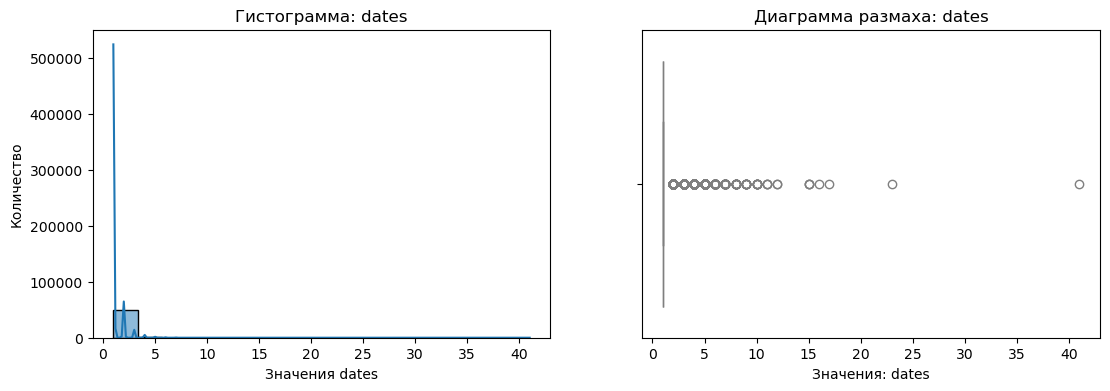

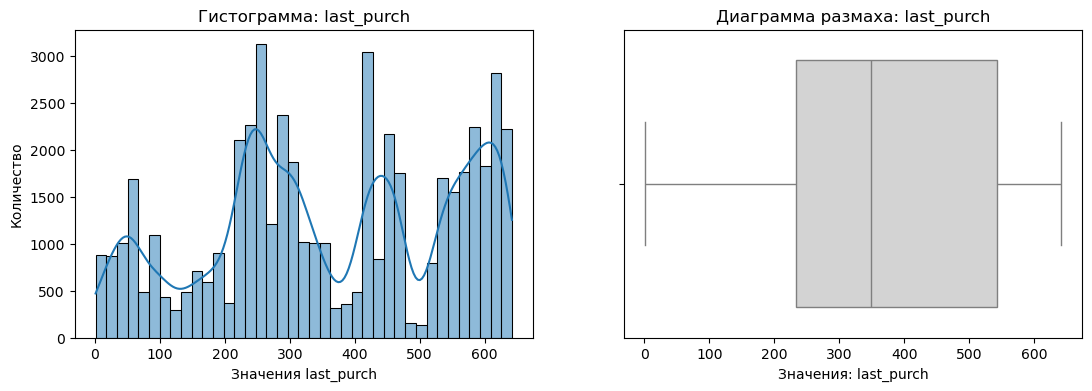

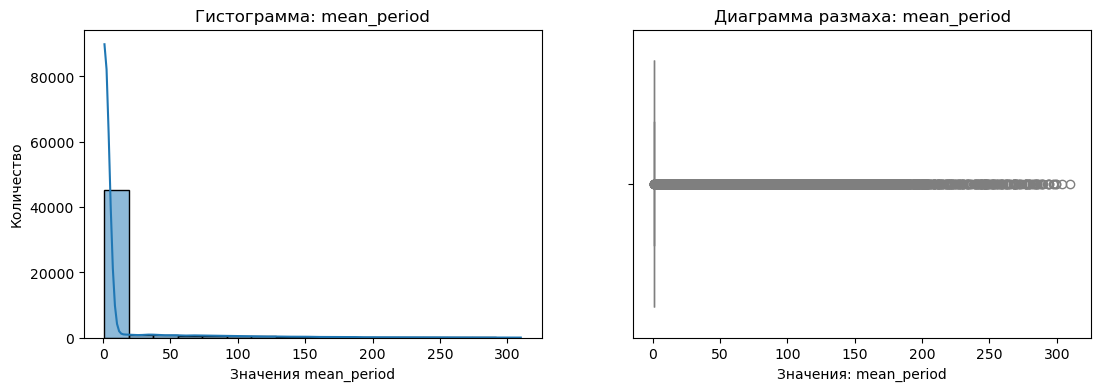

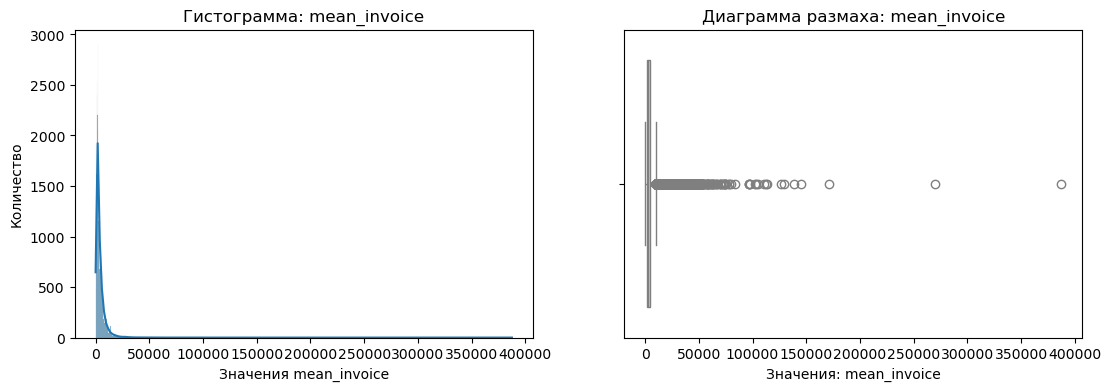

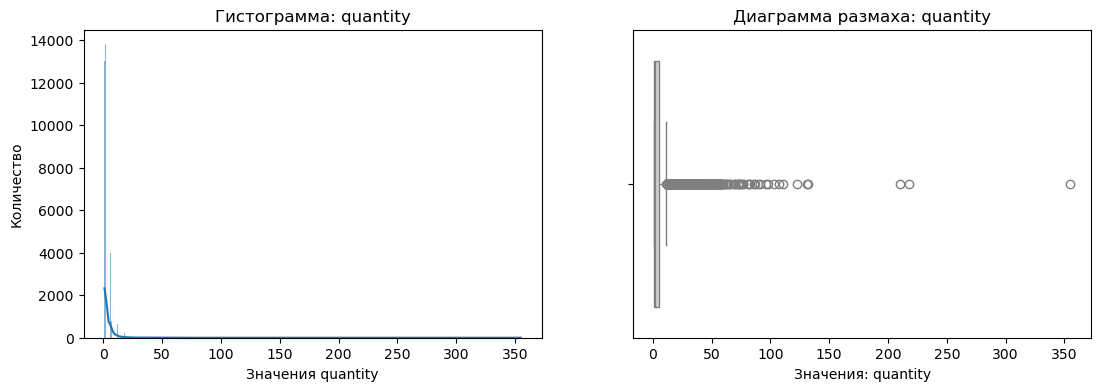

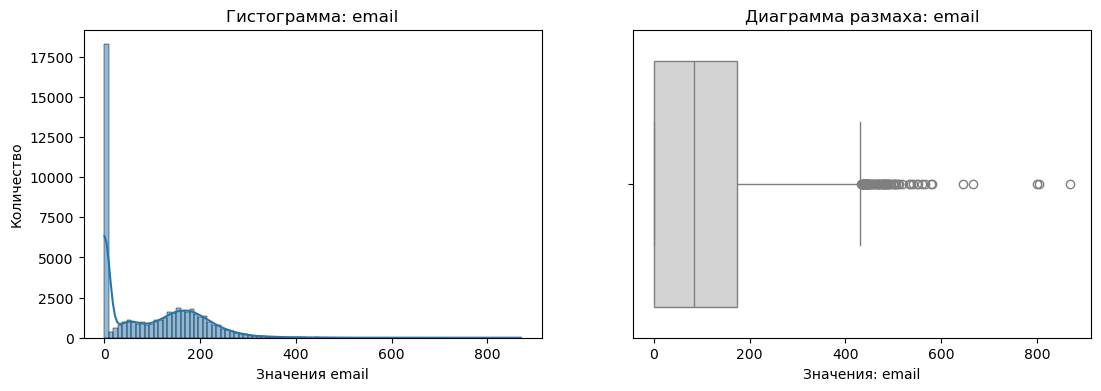

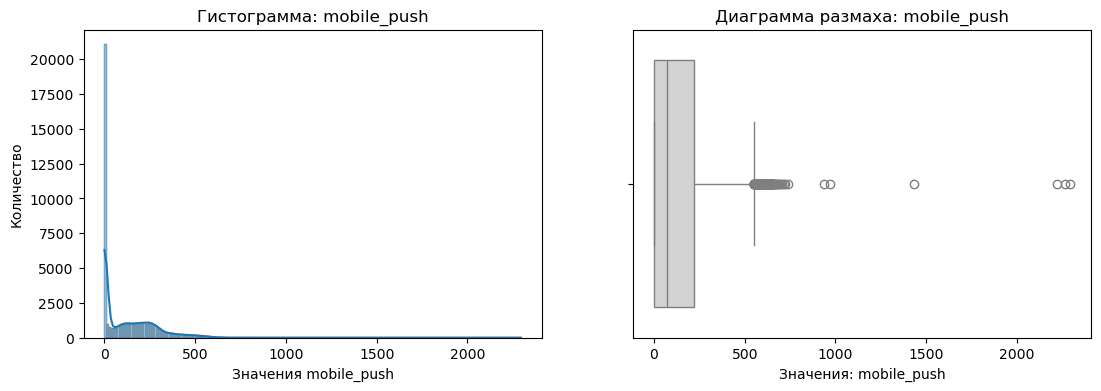

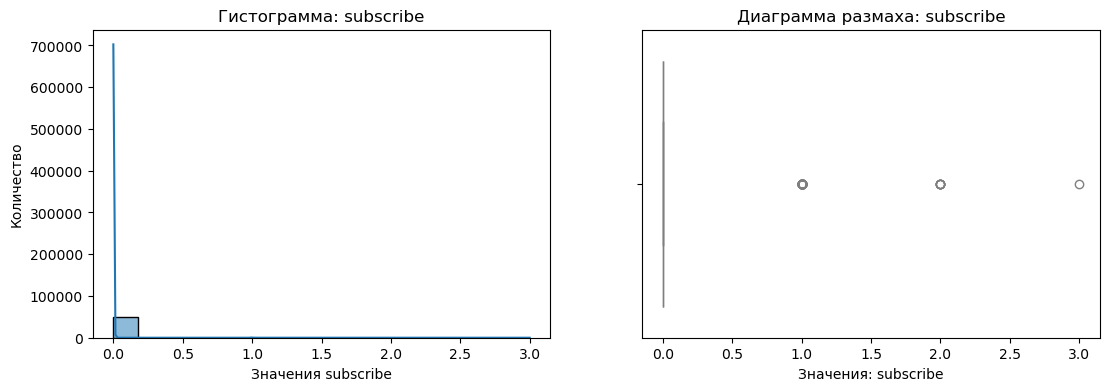

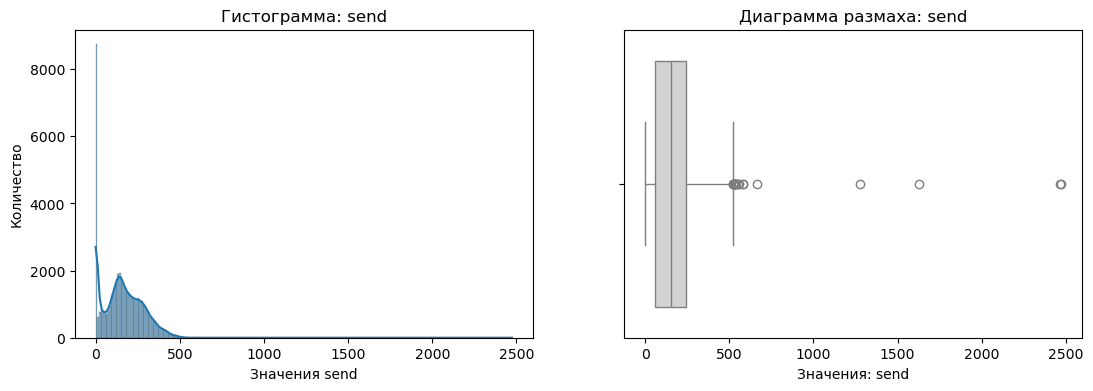

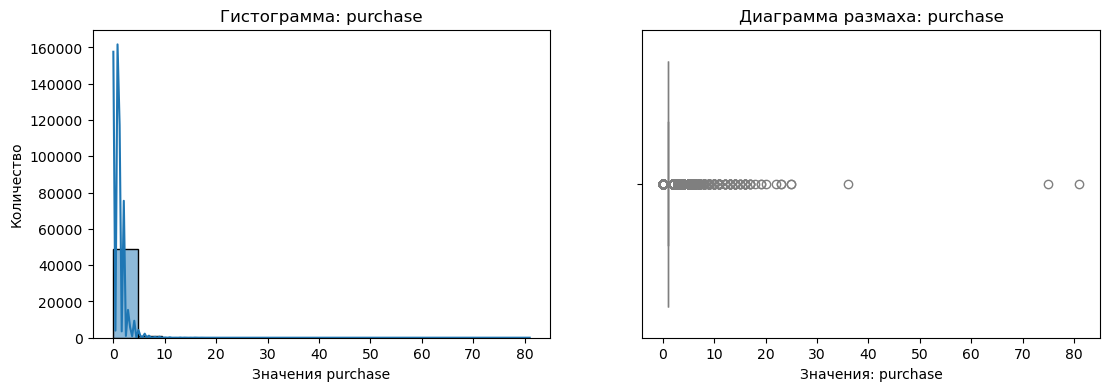

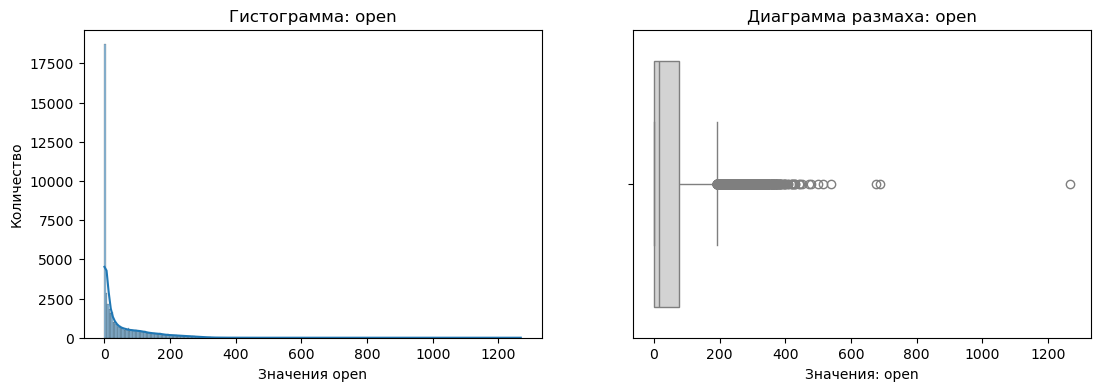

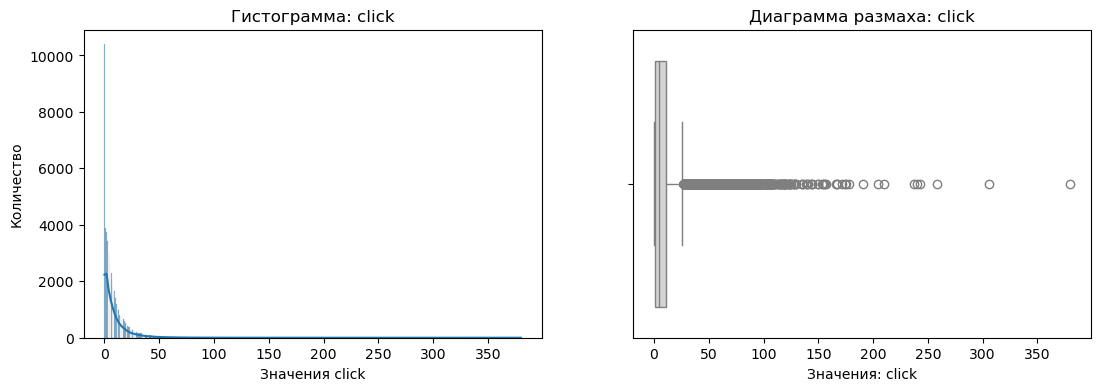

In [265]:
# основная функция:
def hist (data, column):
    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    plt.xlabel(f'Значения {column}')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма: {column}')
    sns.histplot(data=data, x=column, kde=True)
    plt.subplot(1,2,2)
    plt.xlabel(f'Значения: {column}')
    plt.title(f'Диаграмма размаха: {column}')
    sns.boxplot(x=data[column], color='LightGrey')

# числовые данные:
num_col = df_main.select_dtypes(include='number').columns

for row in num_col:
    hist(df_main, row)

**Вывод:**

- **столбец 'target'** - подавляющее кол-во значений это 0, т.к 'target' целевой признак, при train_test_split нужно применить функцию стратификации;
- **столбец 'total_price'** - основной массив значений распределен в промежутке от 0 до 10000, есть единичные значения более 500000. Даже если значение реальное, всё равно является выбросом, от такого лучше избавиться;
- **столбец 'dates'** - также есть аномальные значения по кол-ву дней. Основной диапозон покупок от 0 до 5 дней. Уберем значения больше 40 дней;
- **столбец 'last_purch'** - распределение с 3мя пиками, оставим как есть;
- **столбец 'mean_period'** - основной средний период покупок ориентировочно от 0 до 20 дней. Уберём значения где более 300 дней;
- **столбец 'mean_invoice'** - оставим как есть;
- **столбец 'main_category'** - оставим как есть;
- **столбец 'email'** - оставим как есть;
- **столбец 'mobile_push'** - оставим как есть;
- **столбец 'subscribe'** - оставим как есть;
- **столбец 'purchase'** - оставим как есть.

In [266]:
# формируем фильтры:
df_main = df_main[(df_main['total_price'] < 500000)]
df_main = df_main[(df_main['dates'] < 40)]
df_main = df_main[(df_main['mean_period'] < 300)]

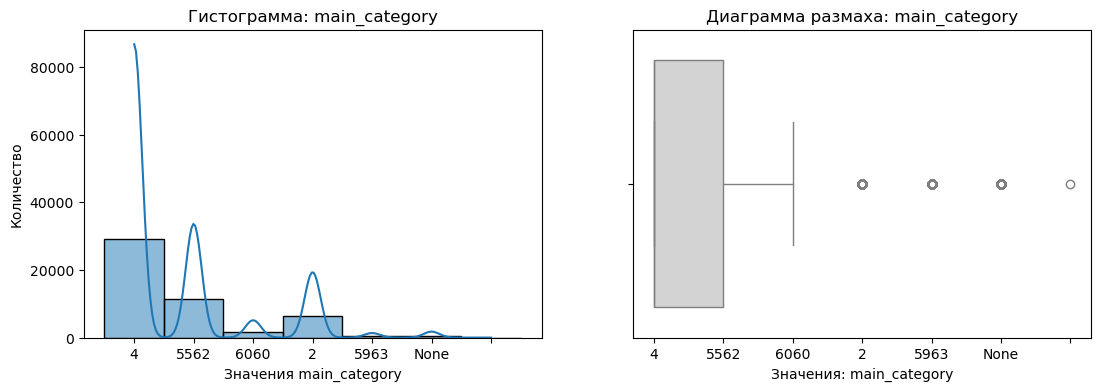

In [267]:
# категориальные данные:
cat_col = df_main.select_dtypes(exclude='number').columns

for row in cat_col:
    hist(df_main, row)

**Вывод: можно выделить 3 топовых категории товаров №4, №5562, №2. К сожалению, пояснений и расшифровок по обозначению нет, поэтому остается только догадываться. Например: продукты питания-электроника-автотовары**

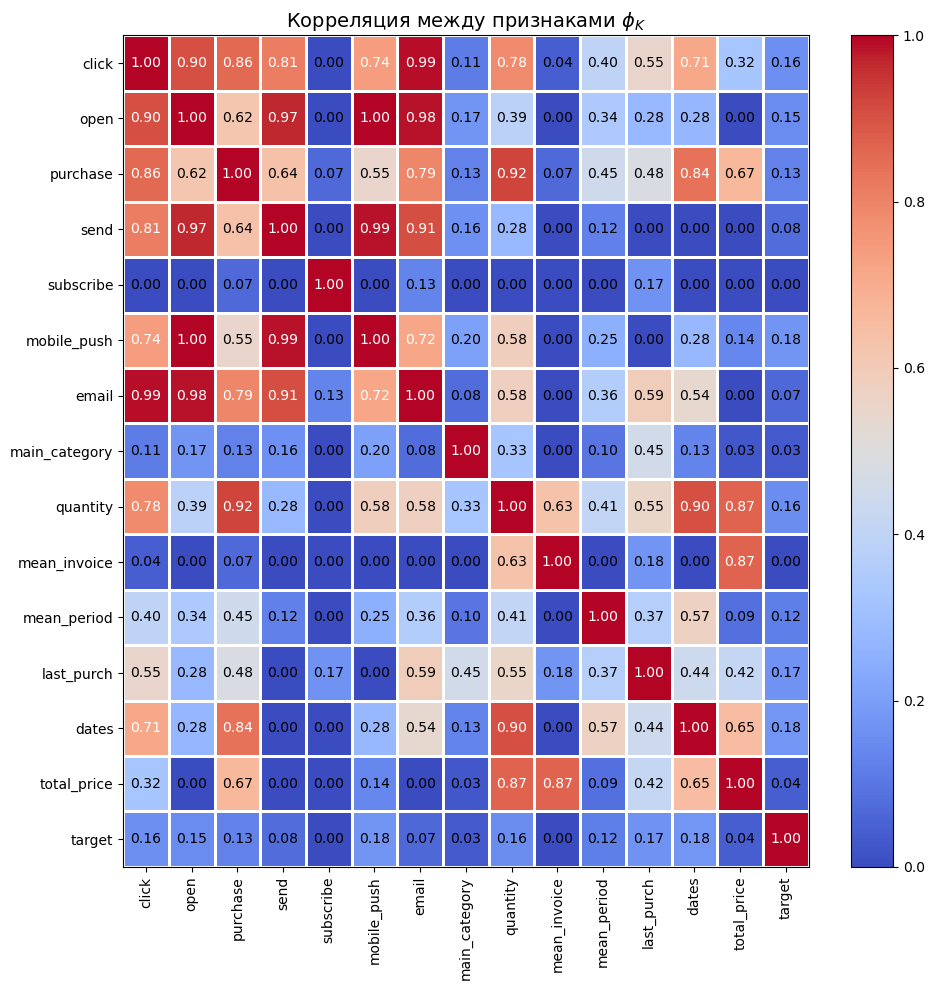

In [268]:
# список интервальных признаков
interval_cols = ['total_price','mean_period','mean_invoice']

# вычисление 1000 коэффициентов корреляции phi для датафрейма df_main
phik_overview = df_main.drop(columns=['client_id']).sample(30000, random_state=RANDOM_STATE).phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    vmin=0, 
    vmax=1, 
    color_map='coolwarm', 
    title=r"Корреляция между признаками $\phi_K$", 
    fontsize_factor=1,                 
    figsize=(10,10)
)

**Вывод: с таргетом у входящих признаков корреляций нет, зато есть между собой. Высокая корреляция у 'click' - 'mean_invoice' - 'open' - 'send', поэтому попробуем их дропнуть по очереди или все вместе, с отслеживанием качества метрики**.

In [269]:
df_main = df_main.drop('click', axis=1)
df_main = df_main.drop('mean_invoice', axis=1)
df_main = df_main.drop('open', axis=1)
df_main = df_main.drop('send', axis=1)
df_main = df_main.drop('client_id', axis=1)

<a class="anchor" id="chapter4"></a>

# Обучение моделей

In [270]:
X = df_main.drop('target', axis=1)
y = df_main['target']

# Разбиваем выборку на тренировочную и тестовую:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify = df_main['target']
)

# формируем переменные с количественными и числовыми данными:
ohe_columns = X_train.select_dtypes(exclude='number').columns
num_columns = X_train.select_dtypes(include='number').columns

# формируем пайплайн для заполнение пропусков и OHE-кодирования признаков из ohe_columns: 
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# формируем общий пайплайн для подготовки данных:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# формируем итоговый пайплайн для подготовки данных и моделей:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели KNeighborsClassifier(): 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,15), 
        'preprocessor__num': [StandardScaler(),  'passthrough']   
    },
    
    #словарь для модели DecisionTreeClassifier():
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,15),
        'models__max_features': range(15,30),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },

    # словарь для модели RandomForestClassifier():
    {
        'models': [RandomForestClassifier()],
        'models__n_estimators':range(50, 60),
        'models__max_depth': range(10, 20),        
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },

     # словарь для модели CatBoostClassifier():
    {
        'models': [CatBoostClassifier(loss_function="Logloss",verbose=False)],
        'models__iterations':range(5, 100),
        'models__max_depth': range(5, 10),   
        'models__learning_rate':[0.1, 0.5, 0.7, 0.8],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    }
]

# формируем рандомный поиск гиперпараметров
my_model = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=40,
    random_state=RANDOM_STATE,
)

# обучаем модель       
my_model.fit(X_train, y_train)

print(f'Лучшие параметры модели: \n', my_model.best_estimator_)
print(f'Метрика лучшей модели на тренировочных данных: \n', my_model.best_score_)

Лучшие параметры модели: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['main_category'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['total_price', 'dates', 'last_purch', 'mean_period', 'quantity',
       'email', 'mobile_push', 'subscribe', 'purchase'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostC

In [271]:
# предсказания на тестовых данных:
y_pred = my_model.predict(X_test)
y_pred_proba = my_model.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовых данных: {round(roc_auc_score(y_test, y_pred_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовых данных: 0.73


**Вывод: Для выполнения задачи по бинарной классификации (0 или 1) были использованы 4 модели классификации: KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), CatBoostClassifier(). Лучшая метрика ROC-AUC на тестовых данных = 0,73 и достигнута моделью CatBoostClassifier() с рандомным поиском гиперпараметров**

<a class="anchor" id="chapter5"></a>

# Анализ лучшей модели

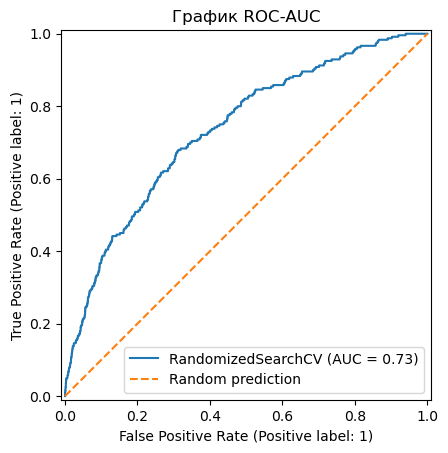

In [272]:
# построим график ROC-кривой модели CatBoostClassifier():
RocCurveDisplay.from_estimator(my_model, X_test, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC")
plt.legend()
plt.show()

**Вывод: ROC-кривая показывает, что модель CatBoostClassifier() выдаёт результат среднего качества.**

Text(0.5, 23.52222222222222, 'Predicted')

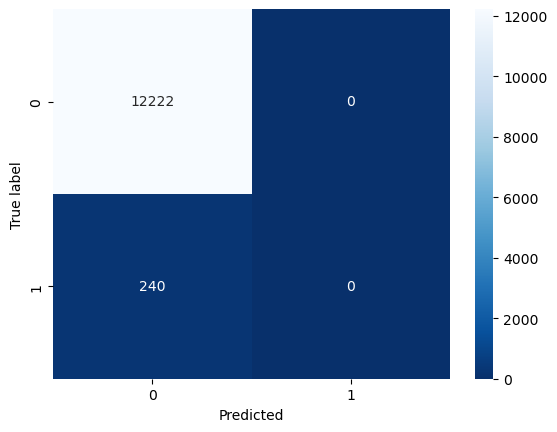

In [273]:
# построим матрицу ошибок:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

**Вывод: TN: верное предсказание класса 0 (кто не купит, но купил) = 12222, FP: Ошибка 1-го рода (кто купит, но не купил) = 0, FN: Ошибка 2-го рода (кто не купит, и не купил) = 240, TP: Верное предсказание класса 1 (кто купит и купил) = 0**

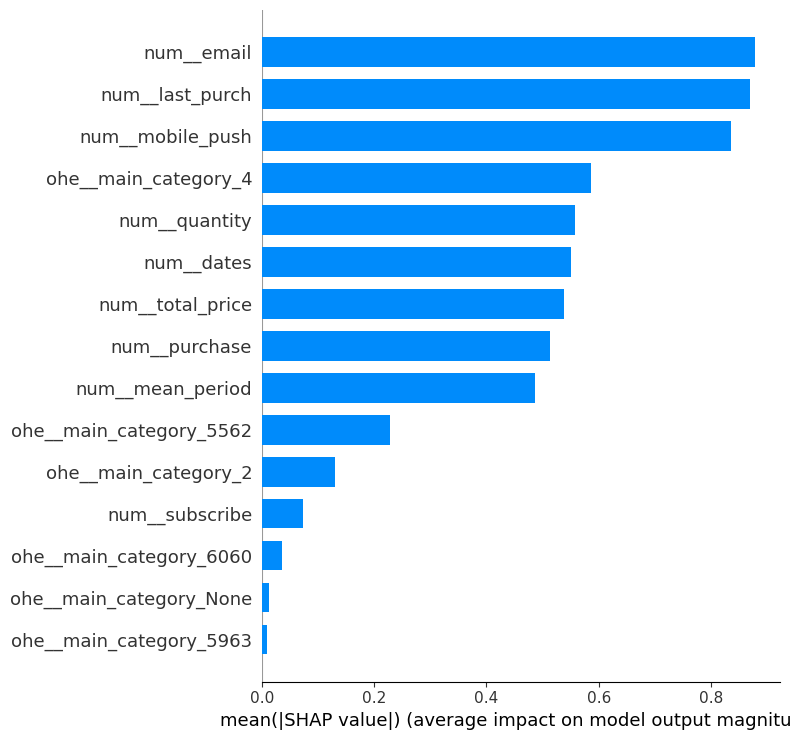

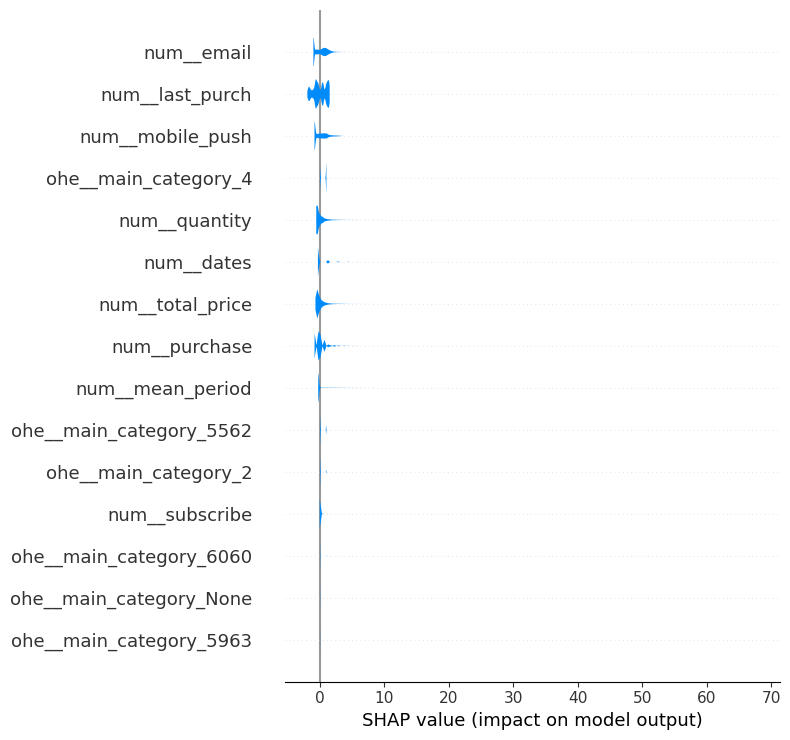

In [274]:
# оценка важности признаков и  график важности с помощью метода SHAP:
values = my_model.best_estimator_['preprocessor'].fit_transform(X_train)
best_model = my_model.best_estimator_['models'].fit(values, y_train)
explainer = shap.PermutationExplainer(best_model, values)
name = my_model.best_estimator_[: -1].get_feature_names_out()
 
shap.summary_plot(
    values, 
    plot_type='bar',
    feature_names=name, 
    plot_size='auto')

shap.summary_plot(
    values, 
    plot_type='violin', 
    feature_names=name, 
    plot_size='auto')

**Вывод: Практически все числовые признаки влияют на целевой показатель, категориальный признак тоже вносит свой вклад, но в меньшей степени.**

<a class="anchor" id="chapter6"></a>

# Итоговый вывод

Для выполнения проекта было использовано три датасета с  данными: история покупок, история рекламных рассылок, и прогнозы совершит ли клиент покупку в течении следующих 90 дней.

**Изучение данных:**

В ходе ознакомления с данными перед дальнейшими исследованиями были реализованы следующие шаги:

- Получена общая информация по датасету;
- Информация в датасете корректна, содержание соответствует наименованиям столбцов;
- Датасет содержит числовые и категориальные значения, а также даты. Целевым  значением являет сtargetce'совершит клиент покупку или нетто)e';


**Предобработка данных:**

**Датасет df_messages**
- пропущенных значений нет, но есть дубликаты которые подтверждаются одинаковым временем создания сообщений;
- есть определенные проблемы по рассылке: сообщения уходят в спам, технические проблемы с доставкой сообщений, жалобы и отписки от клиентов;
- сгруппировали/пересобрали датасет df_messages по столбцу 'client_id' кол-во записей сжалось до 53329 значений. Создали новые полезные признаки ('email', 'mobile_push', 'subscribe', 'send', 'purchase', 'open', 'click') из столбцов 'event' и 'channel'.

**Датасет df_purchases**
- с дубликатами действовал осторожно, т.к скорее всего это не дубликаты, а заказы сделанные одним и тем же клиентом в разное время (например утром и вечером). К тому же, потеря данных могла составить около 30% от всего объёма датасета;
- группировали/пересобрали датасет df_purchases по столбцу 'client_id' кол-во записей сжалось до 49849 значений. Создали новые полезные признаки на основе имеющихся данным.

**Датасет df_target**
- пропущенных значений нет, дублей незамечено, но присутствует дисбаланс таргета. Перед обучением моделей нужна стратификация

**Объединённый датасет df_main (df_purchases_group + df_messages_group + df_target)**
- Получили основной датасет для дальнейшей работы на 49849 записей, пропуски заполнили рандомным распределением значений.

**Исследовательский анализ данных:**

- **столбец 'target'** - подавляющее кол-во значений это 0, т.к 'target' целевой признак, при train_test_split применили функцию стратификации;
- **столбец 'total_price'** - основной массив значений распределен в промежутке от 0 до 10000, было единичное значения более 500000. Даже если значение реальное, всё равно является выбросом, от такого лучше избавиться;
- **столбец 'dates'** - также есть аномальные значения по кол-ву дней. Основной диапозон покупок от 0 до 5 дней. Убрали значения больше 40 дней;
- **столбец 'last_purch'** - распределение с 3мя пиками, оставили как есть;
- **столбец 'mean_period'** - основной средний период покупок ориентировочно от 0 до 20 дней. Убрали значения где более 300 дней;
- **столбцы 'mean_invoice', 'main_category', 'email', 'mobile_push', 'subscribe', 'purchase'** - оставили без изменений;
- **столбец 'main_category'** можно выделить 3 топовых категории товаров №4, №5562, №2. К сожалению, пояснений и расшифровок по обозначению нет, поэтому остается только догадываться что это за категории. Например: продукты питания-электроника-автотовары;
- с таргетом у входящих признаков корреляций нет, зато есть между собой. Высокая корреляция у 'click' - 'mean_invoice' - 'open' - 'send', поэтому  удалили их все вместе, с отслеживанием качества метрики.как есть.


**Обучение моделей:**
- Сделано разделение на тренировочную и тестовую выборки;
- Сформированы переменные с количественными и числовыми данными;- Сформировали общий пайплайн для подготовки данных;
- Сформировали итоговый пайплайн для подготовки данных и моделей;
- Выбранные для машинного обучения модели: KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier
- Использован рандомный поиск гиперпараметров;
- Лучшая метрика ROC-AUC на тестовых данных = 0,74 достигнута моделью CatBoostClassifier().


**Анализ модели:**
- верное предсказание класса 0 (TN) = 12222, Ошибка 1-го рода (FP) = 0, Ошибка 2-го рода (FN) = 240, Верное предсказание класса 1 (TP) = 0;
- практически все числовые признаки влияют на целевой показатель, категориальный признак тоже вносит свой вклад, но в меньшей степени.

**Рекомендации:**
- Подобрать для модели CatBoostClassifier() порог вероятности, чтобы доля верных предсказаний класса 1 (TPR), были как можно ближе к единице, при этом сохраняя долю неверно предсказанных объектов класса 0 (FPR), на самом нижнем из возможных уровней.